In [82]:
%matplotlib inline
import lsst.meas.base as measBase
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.detection as afwDetect
import lsst.daf.persistence as dafPersist
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7.0, 5.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

In [126]:
b_debug = dafPersist.Butler("decam_rescale_test")
forced = b_debug.get("forced_src", visit=197367, ccdnum=10, immediate=True)

Median sigma: 60.1700554265


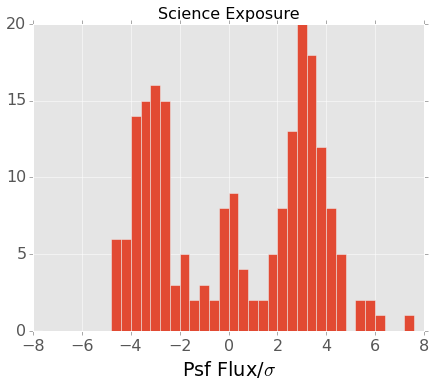

In [31]:
H,bins,_ = plt.hist(forced['base_PsfFlux_flux']/forced['base_PsfFlux_fluxSigma'],
                    bins=40, range=(-8,8))

#x = np.linspace(-400,400,200)
phot_sigma = np.median(forced['base_PsfFlux_fluxSigma'])
#norm = sum(H)/np.sqrt(2*np.pi)/phot_sigma * (bins[1] - bins[0])
#plt.plot(x, norm * np.exp(-x**2/(2*phot_sigma**2)), 'k-')
print "Median sigma:", phot_sigma 
plt.title("Science Exposure", fontsize="medium")
plt.xlabel("Psf Flux/$\sigma$")

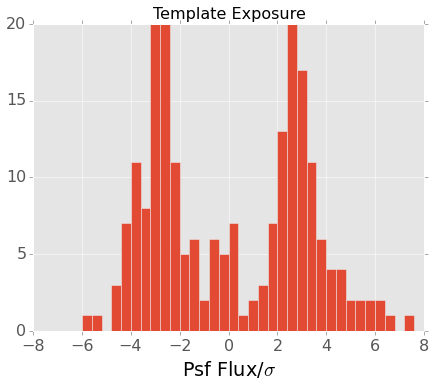

In [8]:
H,bins,_ = plt.hist(forced['template_base_PsfFlux_flux']/forced['template_base_PsfFlux_fluxSigma'],
                    bins=40, range=(-8,8))
plt.title("Template Exposure", fontsize="medium")
plt.xlabel("Psf Flux/$\sigma$")

5.5sigma detections: 1
Positive noise:  91
Negative noise:  80
----
Positive Real 44
Negative Real 64


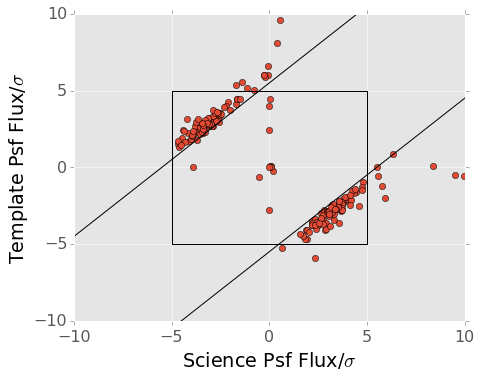

In [32]:
fig = plt.figure()
sum_err = np.sqrt(forced['base_PsfFlux_fluxSigma']**2 +
                  forced['template_base_PsfFlux_fluxSigma']**2)
plt.plot(forced['base_PsfFlux_flux']/forced['base_PsfFlux_fluxSigma'],
         forced['template_base_PsfFlux_flux']/forced['template_base_PsfFlux_fluxSigma'], 'o')

#plt.plot(forced['base_PsfFlux_flux']/sum_err,
#         forced['template_base_PsfFlux_flux']/sum_err, 'o')

detection_sigma = (forced['base_PsfFlux_fluxSigma'] - forced['template_base_PsfFlux_flux'])/sum_err
print("5.5sigma detections: {:d}".format(np.sum(detection_sigma > 5.5)))

plotsize = 10
plt.xlim(-plotsize,plotsize)
plt.ylim(-plotsize,plotsize)
x = np.linspace(-25,25)
plt.plot(x, x-5.5, 'k-')
plt.plot(x, x+5.5, 'k-')
plt.plot(5.0*np.array([-1,-1,1,1,-1]),
         5.0*np.array([-1,1,1,-1,-1]), 'k-')
plt.xlabel("Science Psf Flux/$\sigma$")
plt.ylabel("Template Psf Flux/$\sigma$")

sci_SNR = forced['base_PsfFlux_flux']/forced['base_PsfFlux_fluxSigma']
template_SNR = forced['template_base_PsfFlux_flux']/forced['template_base_PsfFlux_fluxSigma']

positive_noise_det = sum((sci_SNR - template_SNR > 5.0) & (sci_SNR < 5.0) & (sci_SNR > 0))
negative_noise_det = sum((-sci_SNR + template_SNR > 5.0) & (template_SNR < 5.0) & (template_SNR > 0))
print "Positive noise: ", positive_noise_det
print "Negative noise: ", negative_noise_det
print "----"
print "Positive Real", sum((sci_SNR - template_SNR > 5.0) & (sci_SNR > 5.0))
print "Negative Real", sum((-sci_SNR + template_SNR > 5.0) & (template_SNR > 5.0))


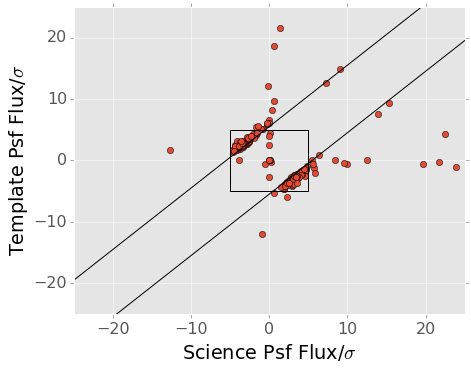

In [33]:
fig.axes[0].set_ylim(-25,25)
fig.axes[0].set_xlim(-25,25)
fig

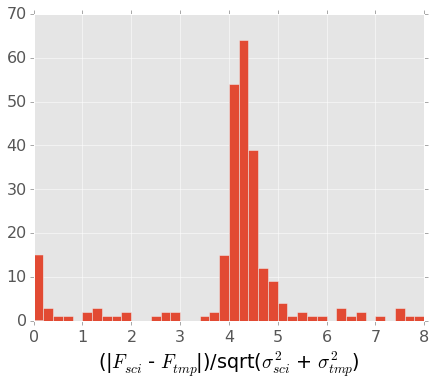

In [117]:
ideal_diffim_SNR = (forced['base_PsfFlux_flux'] - forced['template_base_PsfFlux_flux']) \
                    / np.sqrt(forced['base_PsfFlux_fluxSigma']**2 + forced['template_base_PsfFlux_fluxSigma']**2)

H,bins,_ = plt.hist(np.abs(ideal_diffim_SNR), bins=40, range=(0,8))
plt.xlabel("(|$F_{sci}$ - $F_{tmp}$|)/sqrt($\sigma_{sci}^2$ + $\sigma_{tmp}^2$)")

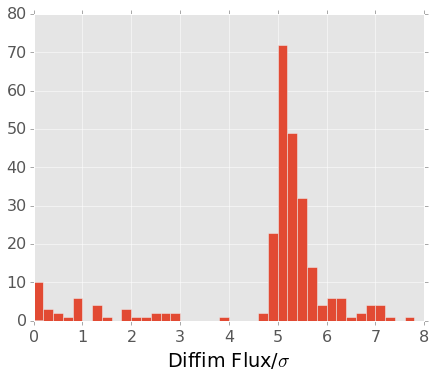

In [36]:
diffim_SNR = forced['diffim_base_PsfFlux_flux']/forced['diffim_base_PsfFlux_fluxSigma']
H,bins,_ = plt.hist(np.abs(diffim_SNR), bins=40, range=(0,8))
plt.xlabel("Diffim Flux/$\sigma$")

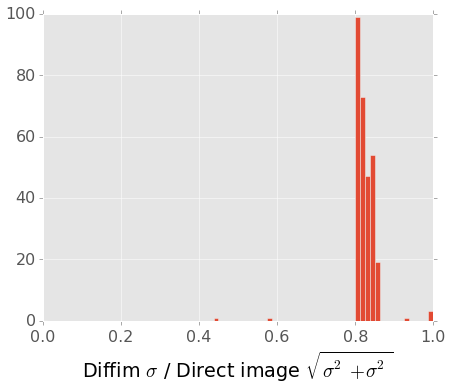

In [116]:
noise_ratio = forced['diffim_base_PsfFlux_fluxSigma'] \
        / np.sqrt(forced['base_PsfFlux_fluxSigma']**2 + forced['template_base_PsfFlux_fluxSigma']**2)

plt.hist(noise_ratio, bins=80, range=(0,1))
np.median(noise_ratio)
plt.xlabel("Diffim $\sigma$ / Direct image $\sqrt{\sigma^2 + \sigma^2}$")

In [70]:
diffim_exp = b_debug.get("deepDiff_differenceExp", visit=197367, ccdnum=10, immediate=True)


/nfs/home/ctslater/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


<matplotlib.colorbar.Colorbar instance at 0x7f6443561b00>

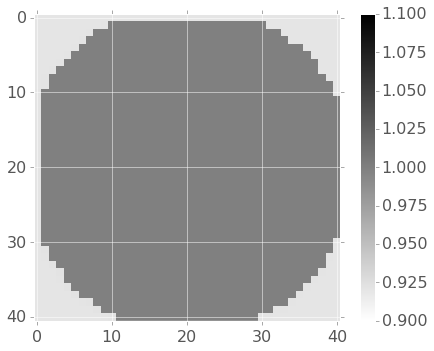

In [75]:
psf = diffim_exp.getPsf()
psfimg = psf.computeImage()
sci_psfimg = sci_img.getPsf().computeImage()
plt.imshow(psfimg.getArray()/sci_psfimg.getArray(), interpolation="none", cmap='gray_r')
plt.colorbar()

In [87]:
calexp = b_debug.get("calexp", visit=197367, ccdnum=10, immediate=True)
matched_exp = b_debug.get("deepDiff_matchedExp", visit=197367, ccdnum=10, immediate=True)

In [120]:
sc = afwMath.StatisticsControl()
sc.setAndMask(afwImage.MaskU.getPlaneBitMask(["INTRP", "EDGE",
                                              "DETECTED", "BAD",
                                              "NO_DATA", "DETECTED_NEGATIVE"]))
stat_flags = afwMath.STDEV | afwMath.MEAN | afwMath.MEDIAN | \
             afwMath.VARIANCE | afwMath.STDEVCLIP

    
calexp_var_stats = afwMath.makeStatistics(calexp.getMaskedImage().getVariance(), stat_flags, sc)
print "Calexp median variance: ", calexp_var_stats.getValue(afwMath.MEDIAN)

warp_var_stats = afwMath.makeStatistics(matched_exp.getMaskedImage().getVariance(), stat_flags, sc)
print "Warp median variance: ", warp_var_stats.getValue(afwMath.MEDIAN)



Calexp median variance:  117.814910889
Warp median variance:  40.1748199463


117.81491088867188

In [100]:
warp_stats = afwMath.makeStatistics(matched_exp.getMaskedImage().getImage(), stat_flags, sc)
print warp_stats.getValue(afwMath.STDEVCLIP)**2
print warp_stats.getValue(afwMath.MEAN)

55.1106698567
428.372991995


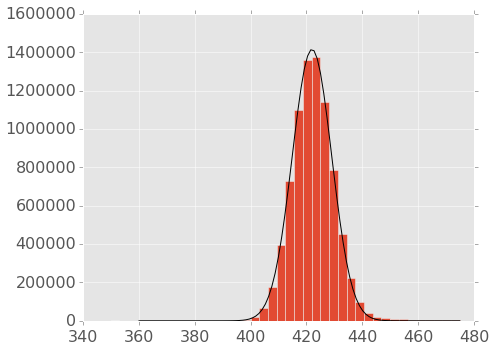

In [123]:
warp_arr = matched_exp.getMaskedImage().getImage().getArray()
warp_var = matched_exp.getMaskedImage().getVariance().getArray()
#plt.hist(warp_arr.flatten()/np.sqrt(warp_var.flatten()), bins=40, range=(-100,400))

H,bins,_ = plt.hist(warp_arr.flatten(), bins=40, range=(350,475))
x = np.linspace(360,475,100)
img_sigma = np.sqrt(50.1)
norm = sum(H)/np.sqrt(2*np.pi)/img_sigma * (bins[1] - bins[0])
plt.plot(x, norm * np.exp(-(x - 422)**2/(2*img_sigma**2)), 'k-')

Classifying and Counting Detections
======

From this single-chip analysis, we can separate the detections into different categories. Detections inside the "5 sigma box", where the source does not correspond to a 5 sigma detection in either direct image,

In [136]:
positive_noise = 0
negative_noise = 0
positive_real = 0
negative_real = 0
dipoles = 0

for ccdnum in xrange(1,59):
    forced_cat = b_debug.get("forced_src", visit=197367, ccdnum=ccdnum, immediate=True)
    
    sel_nondipole, = np.where(forced_cat['classification_dipole'] == 0)
    sci_SNR = forced_cat['base_PsfFlux_flux']/forced_cat['base_PsfFlux_fluxSigma']
    template_SNR = forced_cat['template_base_PsfFlux_flux']/forced_cat['template_base_PsfFlux_fluxSigma']

    sci_SNR = sci_SNR[sel_nondipole]
    template_SNR = template_SNR[sel_nondipole]

    positive_noise_det = sum((sci_SNR - template_SNR > 5.0) & (sci_SNR < 5.0) & (sci_SNR > 0))
    negative_noise_det = sum((-sci_SNR + template_SNR > 5.0) & (template_SNR < 5.0) & (template_SNR > 0))
    
    positive_noise += positive_noise_det
    negative_noise += negative_noise_det
    positive_real += sum((sci_SNR - template_SNR > 5.0) & (sci_SNR > 5.0))
    negative_real += sum((-sci_SNR + template_SNR > 5.0) & (template_SNR > 5.0))
    
    dipoles += np.sum(forced_cat['classification_dipole'] == 1)
    
    
    
area = 54*0.043
print "Positive noise: ", positive_noise, positive_noise/area
print "Negative noise: ", negative_noise, negative_noise/area
print "----"
print "Positive Real", positive_real, positive_real/area
print "Negative Real", negative_real, negative_real/area
print "-----"
print "Dipoles", dipoles, dipoles/area

Positive noise:  6572 2830.31869078
Negative noise:  7519 3238.15676141
----
Positive Real 1717 739.448751077
Negative Real 1954 841.515934539
-----
Dipoles 2764 1190.35314384
